# **Web Scraping of Airline Reviews from the TripAdvisor Website**
Web scraping is an automatic method to obtain large amounts of data from websites. <br>
The purpose of this notebook is to scrape airline reviews from the TripAdvisor website. Airlines included in this notebook are Saudia Airlines, Turkish Airlines, Qatar Airways, Etihad Airways, and Emirates.

*   Saudia Airlines
*   Turkish Airlines
*   Qatar Airways
*   Etihad Airways
*    Emirates

Tripadvisor generates a unique url for each page. Each page url has a generated number of digits, such as **920034765** in the first page 'https://www.tripadvisor.com/ShowUserReviews-g1-d8729069-r920034765-Emirates-World.html', which changes with each page.
<br>  As a result, we will manually take the first page of reviews as input, and the subsequent pages will be extracted by scraping.

# Table of contents
1. [Collecting airline review datasets](#step1) <br>
    1.1 [Collecting the links to the review pages](#step1.1) <br>
    1.2 [Parsing the available data from the collected links](#step1.2)
2. [Collecting gneneral airline rating dataset](#step2)

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup as soup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Collecting airline review datasets** <a name="step1"></a>

### **Collecting the links to the review pages** <a name="step1.1"></a>

The reviews are available in a variety of languages; we have chosen to focus on the English reviews.
The steps are as follows:
1. Find the number of English reviews on the first page.
2. Because each page has 5 reviews, the number of English reviews is divided by 5 to determine the number of pages to be scarpped.
3. Loop through each page to get the next page url, which is then added to a list.
4. Save the list to a text file with the name of the airline.



In [ ]:
def getTheLinks(airline,url):
  firstPage = requests.get(url, headers={'User-Agent': "Mozilla/5.0"})
  html = soup(firstPage.text, 'html.parser')
  # to get number of English pages (each page contains 5 reivew)
  languagesDiv= html.find('div', class_="ui_column is-3 language")
  numReview= languagesDiv.find(lambda tag:tag.name=="li" and "English" in tag.text).find('label').find('span').text[1:-1]
  print('Number of English reviews: ', numReview)
  numReview= int(float(numReview.replace(',', '')))
  # to get int number from the division
  numReview= int(numReview/5)
  print("Number of pages: ",numReview)
  #get the link of the next page from the first page, page 2
  getPageNumber= html.find('div', class_="pageNumbers")
  nextPageUrl= getPageNumber.find_all('a')[1]
  nextPageUrl= nextPageUrl['href']

  #from each page get the link of the next pages, from page 3 to the latest page
  linksList=[]
  #first page
  linksList.append(url)

  #other pages
  for i in range(numReview):
      newHtml= 'https://www.tripadvisor.com/'+nextPageUrl
      page = requests.get(newHtml,headers={'User-Agent': "Mozilla/5.0"})
      reviews= soup(page.text, 'html.parser')
      #get url of the next page
      getPageNumber= reviews.find('div', class_="pageNumbers")
      nextPageUrl= getPageNumber.find_all('a')[-2]
      if(nextPageUrl!='None'):
       nextPageUrl= nextPageUrl['href']
       linksList.append('https://www.tripadvisor.com/'+nextPageUrl)
  #save to txt file
  path= '/content/drive/MyDrive/Colab Notebooks/'+airline+'_reviews_links.txt'
  with open(path, 'w') as f:
    for line in linksList:
        f.write(f"{line}\n")
  print('The links are saved to: ', path)


In [ ]:
#date of collected, 6/10
getTheLinks('saudia','https://www.tripadvisor.com/ShowUserReviews-g1-d8729144-r920017014-Saudia_Airlines-World.html')

Number of English reviews:  2,133
Number of pages:  426
The links are saved to:  /content/drive/MyDrive/Colab Notebooks/saudia_reviews_links.txt


In [ ]:
#date of collected, 6/10
getTheLinks('turkish','https://www.tripadvisor.com/ShowUserReviews-g1-d8729174-r919956577-Turkish_Airlines-World.html')

Number of English reviews:  18,166
Number of pages:  3633
The links are saved to:  /content/drive/MyDrive/Colab Notebooks/turkish_reviews_links.txt


In [ ]:
#date of collected, 7/10
getTheLinks('qatar','https://www.tripadvisor.com/ShowUserReviews-g1-d8729134-r920058188-Qatar_Airways-World.html')

Number of English reviews:  23,052
Number of pages:  4610
The links are saved to:  /content/drive/MyDrive/Colab Notebooks/qatar_reviews_links.txt


In [ ]:
#date of collected, 6/10
getTheLinks('etihad','https://www.tripadvisor.com/ShowUserReviews-g1-d8729074-r919996689-Etihad_Airways-World.html')

Number of English reviews:  13,122
Number of pages:  2624
The links are saved to:  /content/drive/MyDrive/Colab Notebooks/etihad_reviews_links.txt


In [ ]:
# date of collected, 6/10
getTheLinks('emirates','https://www.tripadvisor.com/ShowUserReviews-g1-d8729069-r919683555-Emirates-World.html')

Number of English reviews:  41,917
Number of pages:  8383
The links are saved to:  /content/drive/MyDrive/Colab Notebooks/emirates_reviews_links.txt


### **Parsing the available data from the collected links** <a name="step1.2"></a>

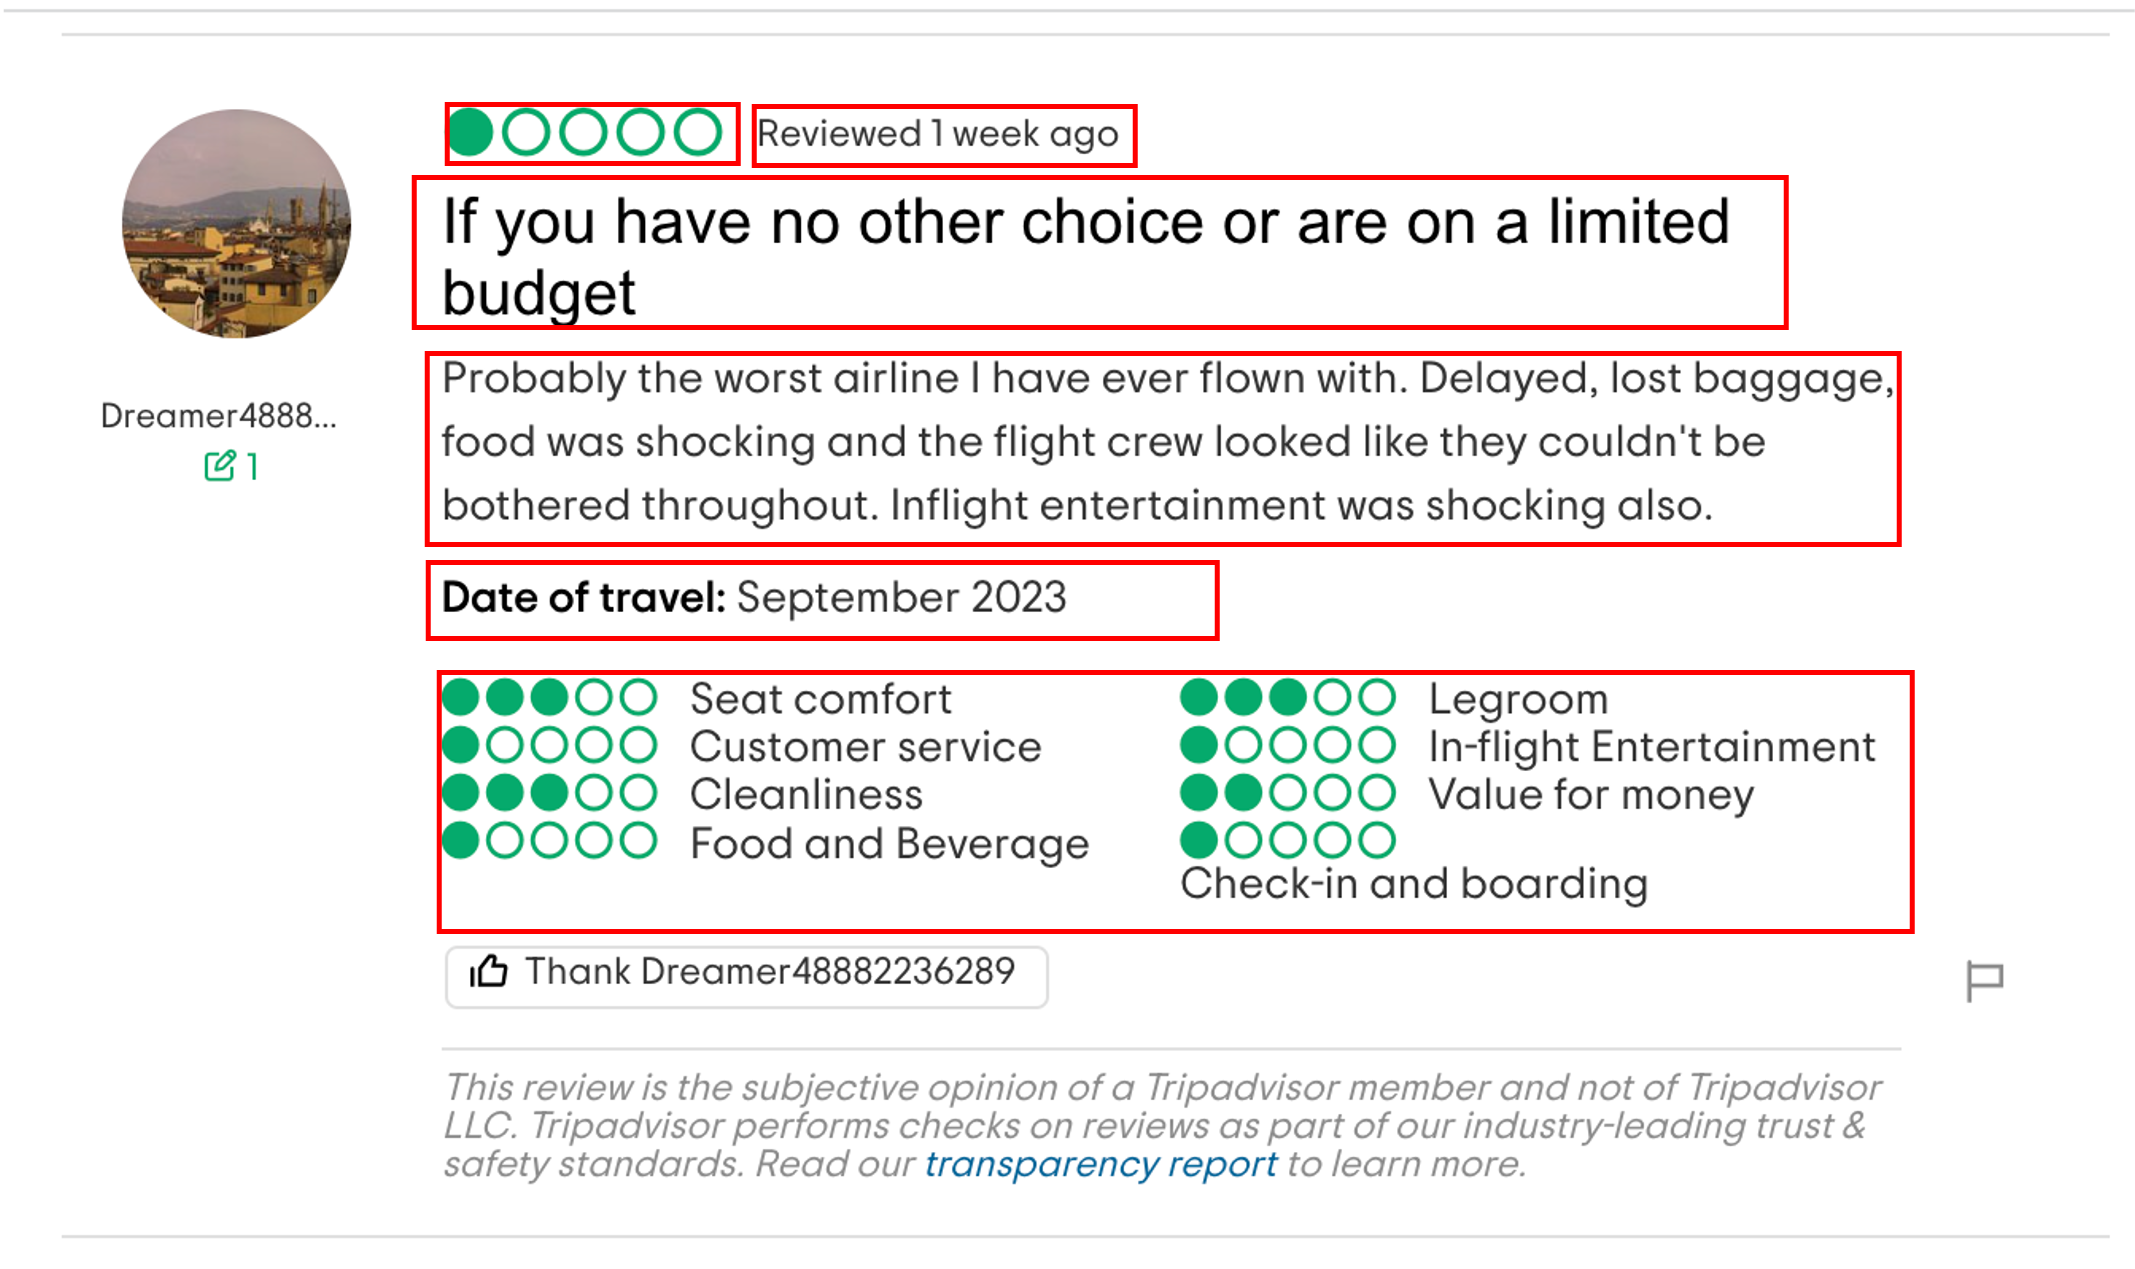

In [ ]:
#number of stars ui_bubble_rating bubble_10
def parse(airline_name, file):

  df = pd.DataFrame(columns=['airline_name', 'review_title', 'review_description', 'review_date','rating_stars', 'travel_date','Seat comfort', 'Customer service', 'Cleanliness', 'Food and Beverage', 'Legroom', 'In-flight Entertainment', 'Value for money', 'Check-in and boarding'])

  with open(file,"r") as f:
    lines = [l for l in (line.strip() for line in f) if l] # Non-blank lines
  for line in lines:
          page = requests.get(line,headers={'User-Agent': "Mozilla/5.0"})
          reviewes= soup(page.text, 'html.parser')
          #get the whole div of review
          reviewDiv= reviewes.find_all('div', class_='innerBubble')
          for i in reviewDiv:
            #get number of stars
            ratingDiv= i.find('div',class_='rating reviewItemInline')
            review_date= ratingDiv.find('span', class_='ratingDate relativeDate')['title']
            #the stars class is "ui_bubble_rating bubble_?0" ? is the number of stars from 1 to 5
            ratingDiv= ratingDiv.find_all('span')[0]
            rating_stars= ratingDiv["class"][1][-2]
            #get review title
            review_title= i.find('span', class_="noQuotes").text
            #get review description
            review_description= i.find('div', class_="prw_rup prw_reviews_text_summary_hsx").text
            #get date of travel
            travel_date= i.find('div',class_="prw_rup prw_reviews_stay_date_hsx").text
            #prw_rup prw_reviews_stay_date_hsx
            df2 = {'airline_name': airline_name, 'review_title': review_title, 'review_description': review_description, 'review_date':review_date,
       'rating_stars': rating_stars, 'travel_date':travel_date, 'Seat comfort':0,
       'Customer service':0,'Cleanliness':0,'Food and Beverage':0,
       'Legroom':0, 'In-flight Entertainment':0, 'Value for money':0,
       'Check-in and boarding':0}

            #get rating list
            ratingList= i.find('div',class_="rating-list")
            if(ratingList!='None'):
                for j in ratingList.find_all('li', class_='recommend-answer'):
                    stars= j.find_all('div')[0]
                    stars= stars["class"][1][-2]
                    des= j.find('div',class_='recommend-description')
                    if des.text in df2.keys():
                        df2[des.text]= stars
            df.loc[len(df)]= df2
  path= '/content/drive/MyDrive/Colab Notebooks/'+airline_name+'_reviews2.csv'
  df.to_csv(path)
  return df


In [ ]:
saudia_df= parse('saudia_airlines', '/content/drive/MyDrive/Colab Notebooks/saudia_reviews_links.txt')
saudia_df.head()

,airline_name,review_title,review_description,review_date,rating_stars,travel_date,Seat comfort,Customer service,Cleanliness,Food and Beverage,Legroom,In-flight Entertainment,Value for money,Check-in and boarding
0,saudia_airlines,If you have no other choice or are on a limite...,Probably the worst airline I have ever flown w...,"October 6, 2023",1,Date of travel: September 2023,3,1,3,1,3,1,2,1
1,saudia_airlines,DO NOT FLY SAUDIA,"unreliable, keeps changing flight times and da...","October 5, 2023",2,Date of travel: October 2023,0,0,0,0,0,0,0,0
2,saudia_airlines,You are fare from Saudi vision 2030,The service on board is perfect. The problem i...,"October 2, 2023",1,Date of travel: August 2023,0,0,0,0,0,0,0,0
3,saudia_airlines,Worst customer service,"Flight Number SV551, from JED to DXB. I would ...","October 2, 2023",1,Date of travel: October 2023,0,1,0,0,0,0,0,1
4,saudia_airlines,Dissatisfaction and unprofessionalism from Sau...,I am writing this about my experience regardin...,"September 30, 2023",1,Date of travel: August 2023,1,1,1,0,1,1,1,1


In [ ]:
turkish_df= parse('turkish_airlines', '/content/drive/MyDrive/Colab Notebooks/turkish_reviews_links.txt')
turkish_df.head()

,airline_name,review_title,review_description,review_date,rating_stars,travel_date,Seat comfort,Customer service,Cleanliness,Food and Beverage,Legroom,In-flight Entertainment,Value for money,Check-in and boarding
0,turkish_airlines,Terrible Airline,"terrible service, seats were not clean, flight...","October 5, 2023",1,Date of travel: May 2023,1,1,1,1,1,1,1,1
1,turkish_airlines,A very pleasant air travel experience!,My recent roundtrip flights from Boston to Kil...,"October 5, 2023",5,Date of travel: September 2023,4,5,5,5,4,4,5,5
2,turkish_airlines,"Never, Never Use Turkish Airlines Economy Class",I can't speak to Turkish Airlines' business cl...,"October 5, 2023",1,Date of travel: January 2023,1,1,3,1,1,3,1,0
3,turkish_airlines,"rude and miserable, horrible treatment","they are horrible at customer service, they de...","October 5, 2023",1,Date of travel: September 2023,1,1,1,1,1,1,1,1
4,turkish_airlines,Thankfully a better experience than some other...,I was reluctant to fly Turkish airlines due to...,"October 5, 2023",4,Date of travel: September 2023,5,3,4,4,5,5,4,4


In [ ]:
etihad_df= parse('etihad_airways','/content/drive/MyDrive/Colab Notebooks/etihad_reviews_links.txt')
etihad_df.head()

,airline_name,review_title,review_description,review_date,rating_stars,travel_date,Seat comfort,Customer service,Cleanliness,Food and Beverage,Legroom,In-flight Entertainment,Value for money,Check-in and boarding
0,etihad_airways,Stop Over on Us program is marketing hype with...,I deliberately scheduled a flight to have a lo...,"October 3, 2023",1,Date of travel: October 2023,0,0,0,0,0,0,0,0
1,etihad_airways,An Overhyped Terrible Airline,I contacted their customer care to resolve an ...,"October 3, 2023",1,Date of travel: September 2023,1,1,2,2,1,2,1,2
2,etihad_airways,Avoid this airline,Pay for upgrade. Get money withdrawn from acco...,"October 3, 2023",1,Date of travel: October 2023,2,1,2,3,2,1,0,1
3,etihad_airways,Sad Etihad,Disappointed with plane offered on this flight...,"October 2, 2023",3,Date of travel: August 2023,1,3,1,2,1,1,1,3
4,etihad_airways,Still waiting for refund!,"After 7 phone calls, no one seems to know what...","October 2, 2023",1,Date of travel: May 2023,0,0,0,0,0,0,0,0


In [ ]:
emirates_df= parse('emirates','/content/drive/MyDrive/Colab Notebooks/emirates_reviews_links.txt')
emirates_df.head()

,airline_name,review_title,review_description,review_date,rating_stars,travel_date,Seat comfort,Customer service,Cleanliness,Food and Beverage,Legroom,In-flight Entertainment,Value for money,Check-in and boarding
0,emirates,Disappointing Experience with Emirates Custome...,My recent flight with Emirates from Dubai to B...,"October 5, 2023",1,Date of travel: October 2023,0,0,0,0,0,0,0,0
1,emirates,Why pay for a seat on already expensive ticket...,It used to be a airline that understood servic...,"October 4, 2023",1,Date of travel: October 2023,0,0,0,0,0,0,0,0
2,emirates,Another good flight with Emirates,Recently flew with Emirates from Hong Kong to ...,"October 4, 2023",4,Date of travel: August 2023,4,3,3,3,5,4,4,4
3,emirates,Wheelchair passangers,I just wanted to inform you an incident and co...,"October 4, 2023",1,Date of travel: September 2023,3,1,4,2,3,3,2,3
4,emirates,Bad service complaint,One of my friend travelled through emirates. A...,"October 4, 2023",2,Date of travel: September 2023,0,0,0,0,0,0,0,0


In [ ]:
qatar_df= parse('qatar_airways','/content/drive/MyDrive/Colab Notebooks/qatar_reviews_links.txt')
qatar_df.head()

,airline_name,review_title,review_description,review_date,rating_stars,travel_date,Seat comfort,Customer service,Cleanliness,Food and Beverage,Legroom,In-flight Entertainment,Value for money,Check-in and boarding
0,qatar_airways,Clean and brand new plane seat,Nice short flight. The plane was a brand new B...,"October 6, 2023",4,Date of travel: October 2023,5,4,5,5,5,0,4,3
1,qatar_airways,Very bad experience,I don't know why Qatar airways is considered o...,"October 6, 2023",2,Date of travel: September 2023,1,2,3,2,1,1,1,2
2,qatar_airways,QATAR AIRWAYS = A PLEASANT EXPERIENCE,I am a frequent airline traveler. For my work ...,"October 6, 2023",5,Date of travel: October 2023,5,5,5,5,5,5,5,5
3,qatar_airways,Joke of an airline,Qatar Airways are a joke. Ryanair are better t...,"October 6, 2023",1,Date of travel: October 2023,0,0,0,0,0,0,0,0
4,qatar_airways,Excellent QR1336 and QR 709,Compliments first....i was suggested by a frie...,"October 6, 2023",4,Date of travel: October 2023,4,4,4,4,4,4,4,4


## **Collecting gneneral airline rating dataset** <a name="step2"></a>
Collecting and parsing general information from the main airline page in tripadvisor

In [ ]:
def generalInfo(airline_name,mainPage):
    html = requests.get(mainPage, headers={'User-Agent': "Mozilla/5.0"})
    html = soup(html.text, 'html.parser')
    stars= html.find('span',class_='ammfn').text
    num_reviews= html.find('span',class_='SSkub').text
    temp= html.find_all('span', class_='ND')
    travelers_choice_winner=[]

    for winner in temp:
        travelers_choice_winner.append(winner.text)

    ratingsDiv= html.find('div', class_='lVVcb JRiqu').find_all('div')

    df2 = {'airline_name': airline_name, 'rating': stars, 'reviews': num_reviews,'travelers_choice_winner':travelers_choice_winner, 'Legroom':'','Seat comfort':'',
            'In-flight entertainment (WiFi, TV, movies)':'', 'Onboard Experience':'', 'Customer service':'',
            'Value for money':'', 'Cleanliness':'', 'Check-in and boarding':'', 'Food and beverage':''}
    for item in ratingsDiv:
        ratingCategory= item.find_all('span')[0].text
        rating= item.find_all('span')[2]["class"][1][-2:]
        rating= rating[0]+'.'+rating[1]
        df2[ratingCategory]= rating
    return df2

In [ ]:
#general rating from the main pages of airlines
saudiaMainPage= 'https://www.tripadvisor.com/Airline_Review-d8729144-Reviews-Saudia-Airlines'
turkishMainPage= 'https://www.tripadvisor.com/Airline_Review-d8729174-Reviews-Turkish-Airlines'
qatarMainPage= 'https://www.tripadvisor.com/Airline_Review-d8729134-Reviews-Qatar-Airways'
etihadMainPage= 'https://www.tripadvisor.com/Airline_Review-d8729074-Reviews-Etihad-Airways'
emiratesMainPage= 'https://www.tripadvisor.com/Airline_Review-d8729069-Reviews-Emirates'
airlinesDict={'saudia_airlines':saudiaMainPage,'turkish_airlines':turkishMainPage,
              'qatar_airways':qatarMainPage,'etihad_airways':etihadMainPage,'emirates':emiratesMainPage}

dfGeneral= pd.DataFrame(columns=['airline_name','rating','reviews','travelers_choice_winner','Legroom','Seat comfort',
                            'In-flight entertainment (WiFi, TV, movies)','Onboard Experience','Customer service','Value for money',
                              'Cleanliness','Check-in and boarding','Food and beverage'])

for key, value in airlinesDict.items():
    dfGeneral.loc[len(dfGeneral)]= generalInfo(key,value)

In [ ]:
dfGeneral.head()

,airline_name,rating,reviews,travelers_choice_winner,Legroom,Seat comfort,"In-flight entertainment (WiFi, TV, movies)",Onboard Experience,Customer service,Value for money,Cleanliness,Check-in and boarding,Food and beverage
0,saudia_airlines,3.0,"3,699 reviews",[Travelers' Choice 2018 Winner],3.5,3.5,3.0,3.5,3.5,3.5,3.5,3.5,3.5
1,turkish_airlines,3.5,"34,480 reviews","[Travelers' Choice 2019 Winner, Travelers' Cho...",3.5,3.5,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,qatar_airways,4.0,"34,700 reviews","[Travelers' Choice 2020 Winner, Travelers' Cho...",4.0,4.0,4.0,4.0,4.0,4.0,4.5,4.0,4.0
3,etihad_airways,3.0,"18,259 reviews","[Travelers' Choice 2018 Winner, Travelers' Cho...",3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.5,3.5
4,emirates,4.0,"64,122 reviews","[Travelers' Choice 2020 Winner, Travelers' Cho...",4.0,4.0,4.5,4.0,4.0,4.0,4.5,4.5,4.0


In [ ]:
dfGeneral.to_csv('/content/drive/MyDrive/Colab Notebooks/generalInfoAirlines.csv')